# Highest Density Regions (HDR)

This notebook provides a deep dive into **highest posterior density (HPD) regions**, also called highest density regions (HDR). Understanding HDR is crucial for interpreting the `hpd_overlap()` metric and for visualizing probability distributions.

**Learning objectives:**
- Understand what highest density regions represent
- Learn how coverage parameters work
- Handle unimodal vs multimodal distributions
- Visualize HDR for different distribution types
- Understand edge cases and limitations

**Previous:** [01_introduction.ipynb](01_introduction.ipynb) | **Next:** [03_time_resolved_diagnostics.ipynb](03_time_resolved_diagnostics.ipynb)

## Setup

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))

from utils import (
    configure_notebook_plotting,
    generate_1d_gaussian_distribution,
    generate_multimodal_distribution,
)

from statespacecheck import highest_density_region, hpd_overlap

configure_notebook_plotting()

## What is a Highest Density Region?

The **highest density region (HDR)** with coverage $\alpha$ is the smallest region that contains at least $\alpha$ probability mass, where all points inside have higher density than points outside.

**Formal definition:**
$$R_\alpha = \{x : p(x) \geq p^*\}$$

where $p^*$ is chosen such that $\int_{R_\alpha} p(x)dx \geq \alpha$

**Key properties:**
- Contains at least $\alpha$ of the probability mass
- Smallest region with that coverage (most compact)
- Can be non-contiguous for multimodal distributions
- Points inside have higher density than points outside

**Intuition:** "Where is the probability mass concentrated?"

## Example 1: Unimodal Distribution

Let's start with a simple Gaussian distribution and visualize its 95% HDR.

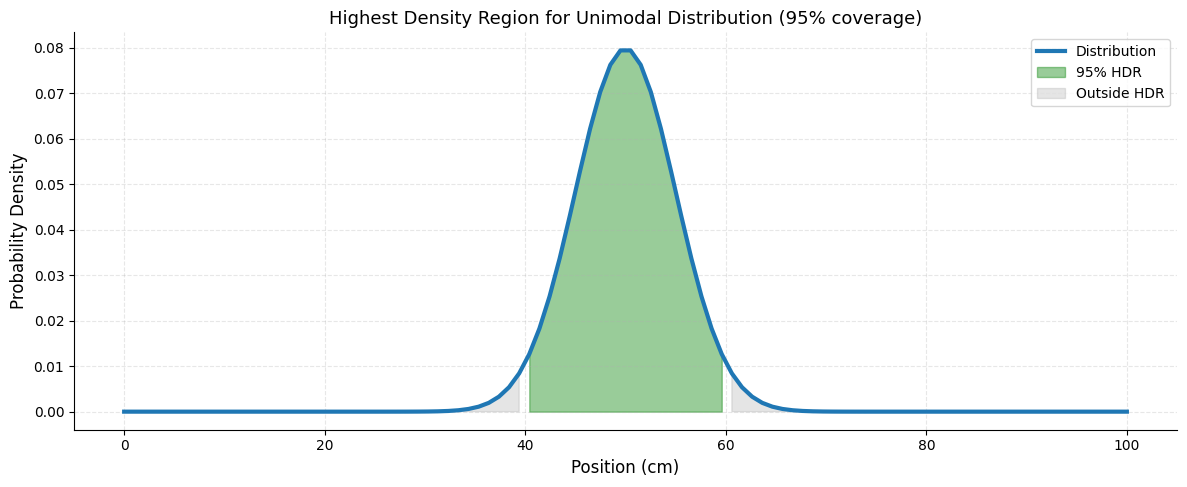

HDR coverage: 20.0% of bins
Probability mass in HDR: 0.947
Total probability mass: 0.990


In [2]:
# Create position bins
position_bins = np.linspace(0, 100, 100)

# Generate unimodal distribution
dist_unimodal = generate_1d_gaussian_distribution(position_bins, mean=50.0, std=5.0)

# Compute 95% HDR
dist_2d = dist_unimodal[np.newaxis, :]  # Add time dimension
hdr_mask = highest_density_region(dist_2d, coverage=0.95)[0]  # Get first (only) time point

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(position_bins, dist_unimodal, linewidth=3, color="#1f77b4", label="Distribution")
ax.fill_between(
    position_bins, 0, dist_unimodal, where=hdr_mask, alpha=0.4, color="green", label="95% HDR"
)
ax.fill_between(
    position_bins, 0, dist_unimodal, where=~hdr_mask, alpha=0.2, color="gray", label="Outside HDR"
)
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Highest Density Region for Unimodal Distribution (95% coverage)")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

# Print statistics
print(f"HDR coverage: {hdr_mask.sum() / len(hdr_mask) * 100:.1f}% of bins")
print(f"Probability mass in HDR: {dist_unimodal[hdr_mask].sum():.3f}")
print(f"Total probability mass: {dist_unimodal.sum():.3f}")

### Interpretation

The green region shows where the distribution concentrates its probability mass:
- The HDR is a **contiguous interval** for unimodal distributions
- It captures the **central high-density region** around the peak
- The tails (gray) are excluded because they have lower density
- The region is **symmetric** for symmetric distributions

Note: We're working with discrete distributions (histograms), so the actual coverage may slightly exceed 95% due to bin granularity.

## Effect of Coverage Parameter

The `coverage` parameter controls how much probability mass to include. Let's visualize multiple coverage levels.

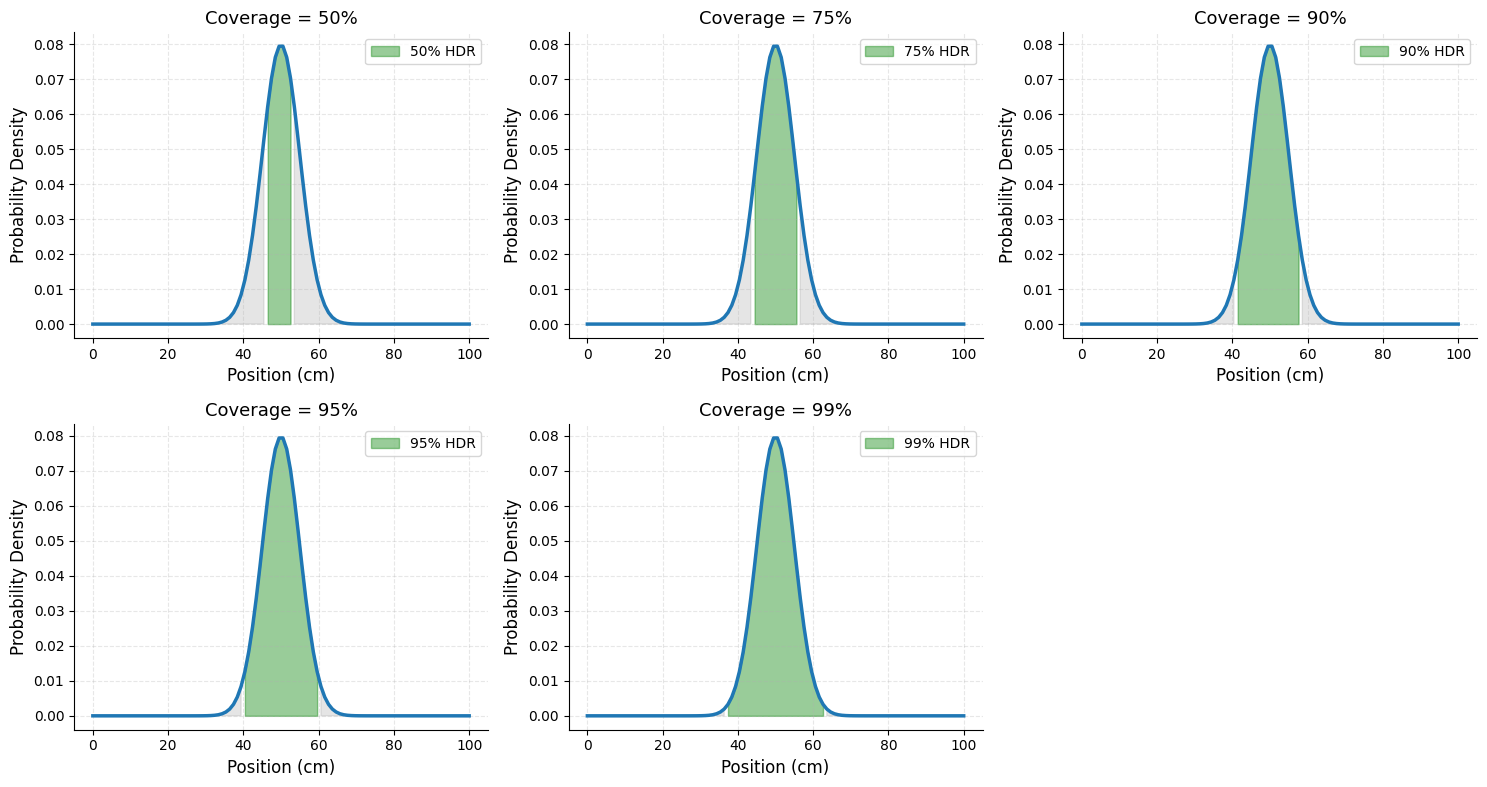

In [3]:
# Test different coverage values
coverages = [0.50, 0.75, 0.90, 0.95, 0.99]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, cov in enumerate(coverages):
    hdr = highest_density_region(dist_2d, coverage=cov)[0]

    axes[idx].plot(position_bins, dist_unimodal, linewidth=2.5, color="#1f77b4")
    axes[idx].fill_between(
        position_bins, 0, dist_unimodal, where=hdr, alpha=0.4, color="green", label=f"{cov:.0%} HDR"
    )
    axes[idx].fill_between(position_bins, 0, dist_unimodal, where=~hdr, alpha=0.2, color="gray")
    axes[idx].set_xlabel("Position (cm)")
    axes[idx].set_ylabel("Probability Density")
    axes[idx].set_title(f"Coverage = {cov:.0%}")
    axes[idx].legend(frameon=True, loc="upper right")

# Remove empty subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()

### Key Observations

As coverage increases:
- HDR **expands** to include more probability mass
- **50% HDR**: Very tight, only the highest peak
- **95% HDR**: Standard choice, balances informativeness and coverage
- **99% HDR**: Very wide, includes almost everything

**Choosing coverage:**
- **95%** is conventional (like confidence intervals)
- Higher coverage is more conservative but less informative
- Lower coverage is more selective but may miss important regions

## Example 2: Multimodal Distribution

HDR becomes more interesting (and useful!) with multimodal distributions. Let's create a bimodal distribution.

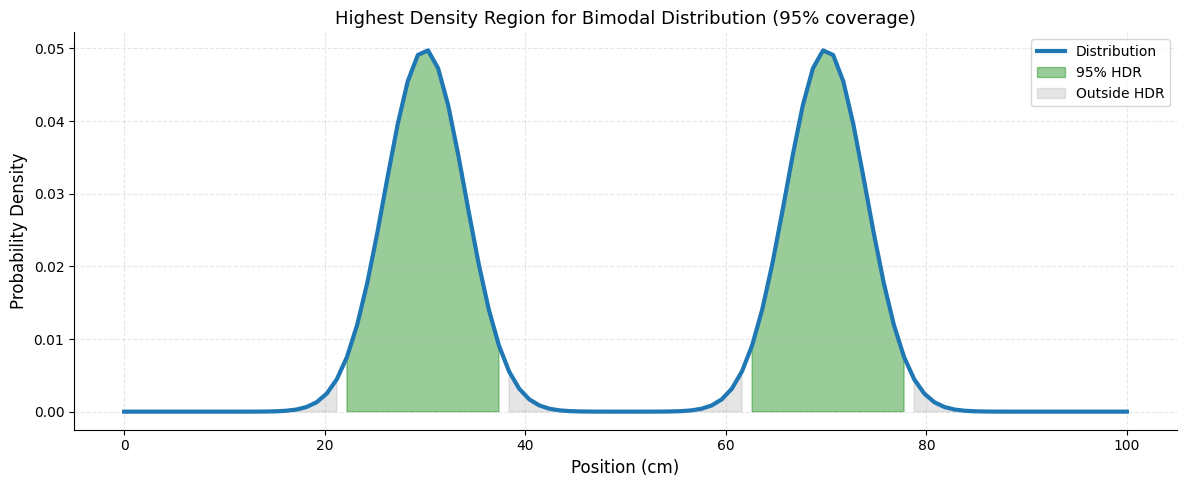

Number of HDR regions: 2 (non-contiguous)
Probability mass in HDR: 0.947


In [4]:
# Generate bimodal distribution (mixture of two Gaussians)
dist_bimodal = generate_multimodal_distribution(
    position_bins, means=[30.0, 70.0], stds=[4.0, 4.0], weights=[0.5, 0.5]
)

# Compute 95% HDR
dist_bimodal_2d = dist_bimodal[np.newaxis, :]
hdr_bimodal = highest_density_region(dist_bimodal_2d, coverage=0.95)[0]

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(position_bins, dist_bimodal, linewidth=3, color="#1f77b4", label="Distribution")
ax.fill_between(
    position_bins, 0, dist_bimodal, where=hdr_bimodal, alpha=0.4, color="green", label="95% HDR"
)
ax.fill_between(
    position_bins,
    0,
    dist_bimodal,
    where=~hdr_bimodal,
    alpha=0.2,
    color="gray",
    label="Outside HDR",
)
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Highest Density Region for Bimodal Distribution (95% coverage)")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

print("Number of HDR regions: 2 (non-contiguous)")
print(f"Probability mass in HDR: {dist_bimodal[hdr_bimodal].sum():.3f}")

### Key Insight

**HDR for multimodal distributions:**
- Can be **non-contiguous** (multiple separated regions)
- Includes all regions with sufficiently high density
- Excludes the low-density valley between peaks
- This is a key advantage over simple credible intervals (which must be contiguous)

**Why this matters for neuroscience:**
- Neural representations can be multimodal (e.g., head direction cells with symmetric responses)
- State uncertainty during decision-making (two possible choices)
- Place cells with multiple fields

## Comparing Different Multimodal Structures

Let's examine how HDR handles different types of multimodal distributions.

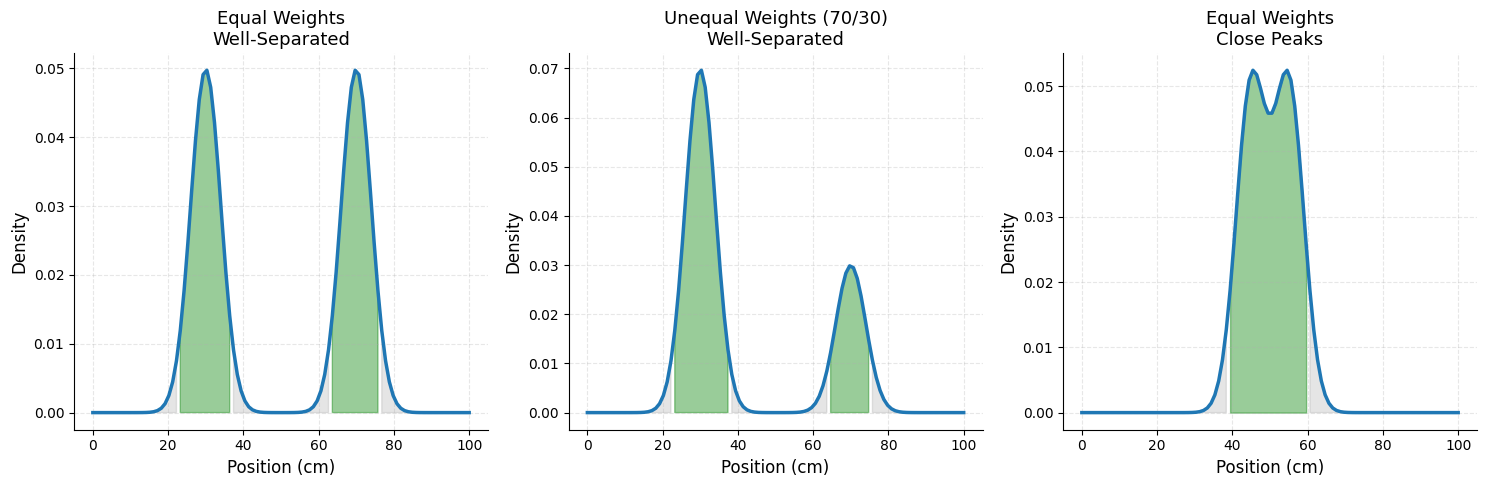

In [5]:
# Create three different bimodal distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Case 1: Equal weights, well-separated
dist1 = generate_multimodal_distribution(
    position_bins, means=[30, 70], stds=[4, 4], weights=[0.5, 0.5]
)
dist1_2d = dist1[np.newaxis, :]
hdr1 = highest_density_region(dist1_2d, coverage=0.90)[0]

axes[0].plot(position_bins, dist1, linewidth=2.5, color="#1f77b4")
axes[0].fill_between(position_bins, 0, dist1, where=hdr1, alpha=0.4, color="green")
axes[0].fill_between(position_bins, 0, dist1, where=~hdr1, alpha=0.2, color="gray")
axes[0].set_title("Equal Weights\nWell-Separated")
axes[0].set_xlabel("Position (cm)")
axes[0].set_ylabel("Density")

# Case 2: Unequal weights (70/30 split)
dist2 = generate_multimodal_distribution(
    position_bins, means=[30, 70], stds=[4, 4], weights=[0.7, 0.3]
)
dist2_2d = dist2[np.newaxis, :]
hdr2 = highest_density_region(dist2_2d, coverage=0.90)[0]

axes[1].plot(position_bins, dist2, linewidth=2.5, color="#1f77b4")
axes[1].fill_between(position_bins, 0, dist2, where=hdr2, alpha=0.4, color="green")
axes[1].fill_between(position_bins, 0, dist2, where=~hdr2, alpha=0.2, color="gray")
axes[1].set_title("Unequal Weights (70/30)\nWell-Separated")
axes[1].set_xlabel("Position (cm)")
axes[1].set_ylabel("Density")

# Case 3: Close peaks (potentially overlapping HDR)
dist3 = generate_multimodal_distribution(
    position_bins, means=[45, 55], stds=[4, 4], weights=[0.5, 0.5]
)
dist3_2d = dist3[np.newaxis, :]
hdr3 = highest_density_region(dist3_2d, coverage=0.90)[0]

axes[2].plot(position_bins, dist3, linewidth=2.5, color="#1f77b4")
axes[2].fill_between(position_bins, 0, dist3, where=hdr3, alpha=0.4, color="green")
axes[2].fill_between(position_bins, 0, dist3, where=~hdr3, alpha=0.2, color="gray")
axes[2].set_title("Equal Weights\nClose Peaks")
axes[2].set_xlabel("Position (cm)")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.show()

### Key Observations

**Left (equal, separated):** HDR cleanly separates into two regions

**Middle (unequal, separated):** HDR focuses more on the dominant peak. The smaller peak may be partially or fully excluded if coverage is low enough.

**Right (close peaks):** When peaks are close, the HDR becomes nearly contiguous. The valley between peaks has high enough density to be included.

**Practical implication:** HDR adapts to the distribution structure automatically.

## HDR Overlap Between Distributions

Now let's understand how `hpd_overlap()` works by visualizing the overlap between two distributions' HDRs.

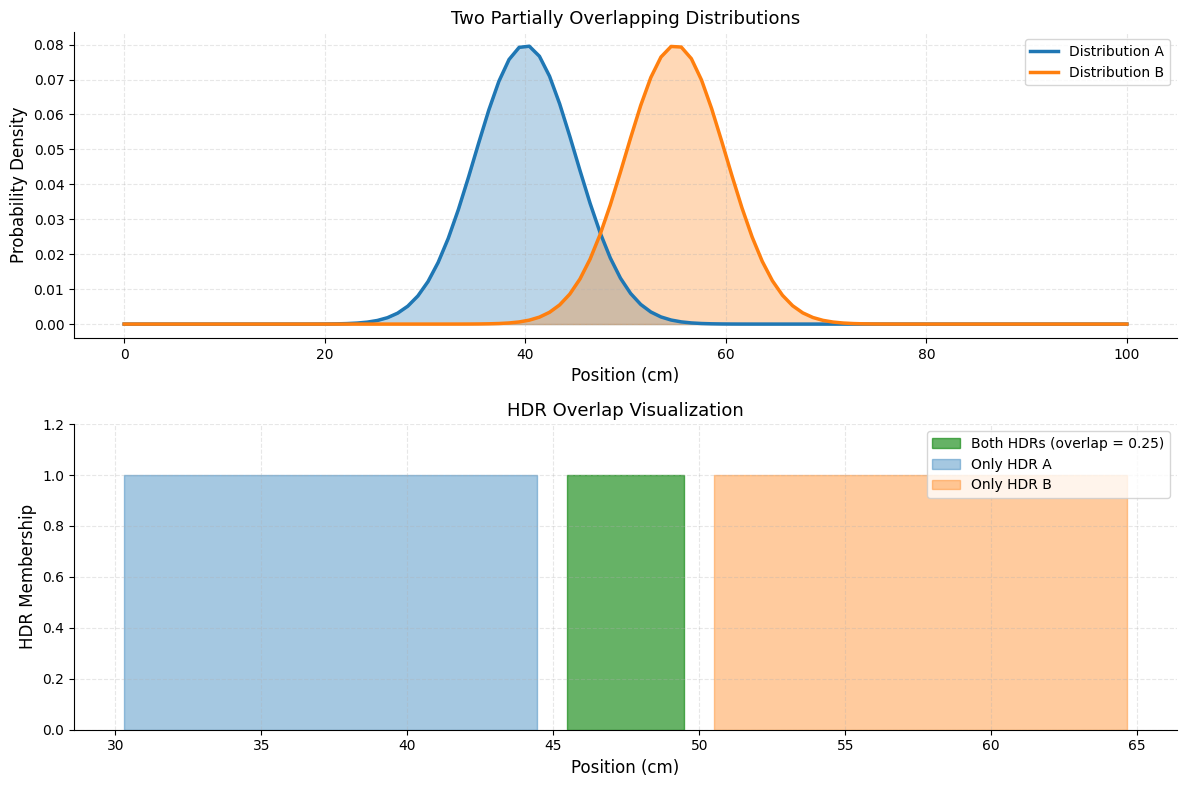

HDR overlap: 0.250
Interpretation: 25.0% of the smaller HDR overlaps with the larger HDR


In [6]:
# Create two partially overlapping distributions
dist_a = generate_1d_gaussian_distribution(position_bins, mean=40.0, std=5.0)
dist_b = generate_1d_gaussian_distribution(position_bins, mean=55.0, std=5.0)

# Add time dimension
dist_a_2d = dist_a[np.newaxis, :]
dist_b_2d = dist_b[np.newaxis, :]

# Compute HDRs
hdr_a = highest_density_region(dist_a_2d, coverage=0.95)[0]
hdr_b = highest_density_region(dist_b_2d, coverage=0.95)[0]

# Compute overlap
overlap = hpd_overlap(dist_a_2d, dist_b_2d, coverage=0.95)[0]

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: Both distributions
ax1.plot(position_bins, dist_a, linewidth=2.5, color="#1f77b4", label="Distribution A")
ax1.plot(position_bins, dist_b, linewidth=2.5, color="#ff7f0e", label="Distribution B")
ax1.fill_between(position_bins, dist_a, alpha=0.3, color="#1f77b4")
ax1.fill_between(position_bins, dist_b, alpha=0.3, color="#ff7f0e")
ax1.set_xlabel("Position (cm)")
ax1.set_ylabel("Probability Density")
ax1.set_title("Two Partially Overlapping Distributions")
ax1.legend(frameon=True, loc="upper right")

# Bottom: HDR visualization
ax2.fill_between(
    position_bins,
    0,
    1,
    where=hdr_a & hdr_b,
    alpha=0.6,
    color="green",
    label=f"Both HDRs (overlap = {overlap:.2f})",
)
ax2.fill_between(
    position_bins, 0, 1, where=hdr_a & ~hdr_b, alpha=0.4, color="#1f77b4", label="Only HDR A"
)
ax2.fill_between(
    position_bins, 0, 1, where=~hdr_a & hdr_b, alpha=0.4, color="#ff7f0e", label="Only HDR B"
)
ax2.set_xlabel("Position (cm)")
ax2.set_ylabel("HDR Membership")
ax2.set_title("HDR Overlap Visualization")
ax2.set_ylim([0, 1.2])
ax2.legend(frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

print(f"HDR overlap: {overlap:.3f}")
print(f"Interpretation: {overlap * 100:.1f}% of the smaller HDR overlaps with the larger HDR")

### Understanding the Overlap Metric

The overlap is computed as:
$$\text{overlap} = \frac{|R_A \cap R_B|}{\min(|R_A|, |R_B|)}$$

**Why normalize by minimum size?**
- Makes overlap **symmetric** and interpretable
- Value of 1.0 means one HDR is fully contained in the other
- Value of 0.0 means no spatial overlap
- Intermediate values show partial agreement

**Interpretation guide:**
- **> 0.7**: High spatial agreement
- **0.3 - 0.7**: Moderate agreement
- **< 0.3**: Low agreement (distributions in different regions)

## Varying Overlap: A Spectrum

Let's explore how overlap changes as we move distributions apart.

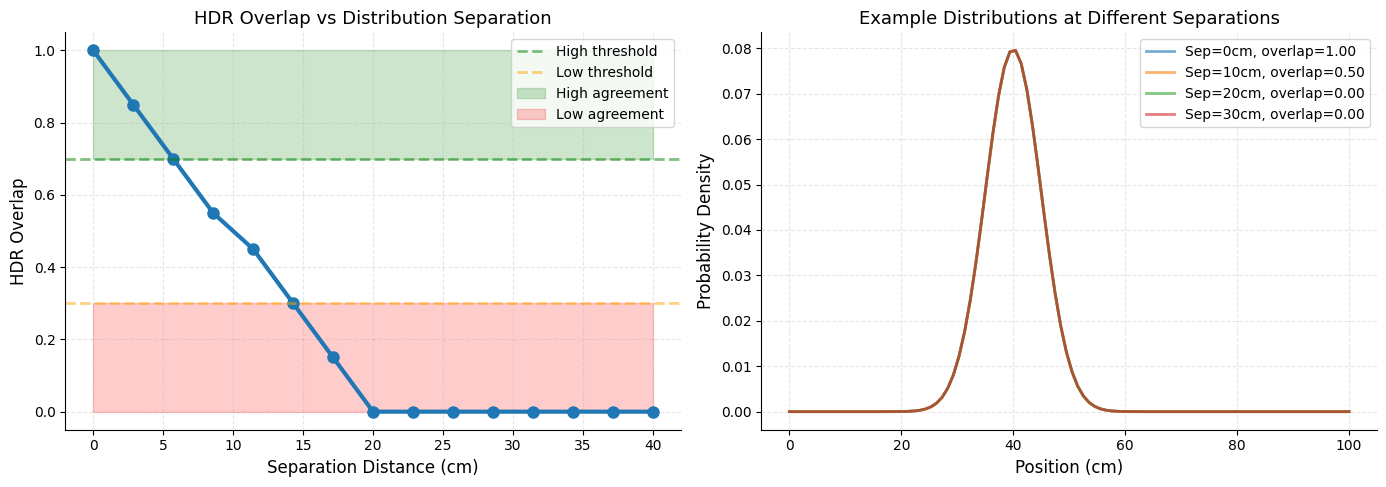

In [7]:
# Generate distributions with varying separation
separations = np.linspace(0, 40, 15)
overlaps = []

for sep in separations:
    dist1 = generate_1d_gaussian_distribution(position_bins, mean=40.0, std=5.0)
    dist2 = generate_1d_gaussian_distribution(position_bins, mean=40.0 + sep, std=5.0)

    dist1_2d = dist1[np.newaxis, :]
    dist2_2d = dist2[np.newaxis, :]

    overlap_val = hpd_overlap(dist1_2d, dist2_2d, coverage=0.95)[0]
    overlaps.append(overlap_val)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overlap vs separation
ax1.plot(separations, overlaps, linewidth=3, marker="o", markersize=8, color="#1f77b4")
ax1.axhline(0.7, color="green", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax1.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax1.fill_between(separations, 0.7, 1.0, alpha=0.2, color="green", label="High agreement")
ax1.fill_between(separations, 0, 0.3, alpha=0.2, color="red", label="Low agreement")
ax1.set_xlabel("Separation Distance (cm)")
ax1.set_ylabel("HDR Overlap")
ax1.set_title("HDR Overlap vs Distribution Separation")
ax1.legend(frameon=True, loc="upper right")
ax1.grid(True, alpha=0.3)

# Right: Example distributions at different separations
example_seps = [0, 10, 20, 30]
for sep in example_seps:
    dist1 = generate_1d_gaussian_distribution(position_bins, mean=40.0, std=5.0)
    dist2 = generate_1d_gaussian_distribution(position_bins, mean=40.0 + sep, std=5.0)
    dist1_2d = dist1[np.newaxis, :]
    dist2_2d = dist2[np.newaxis, :]
    overlap_val = hpd_overlap(dist1_2d, dist2_2d, coverage=0.95)[0]

    ax2.plot(
        position_bins,
        dist1,
        alpha=0.6,
        linewidth=2,
        label=f"Sep={sep}cm, overlap={overlap_val:.2f}",
    )

ax2.set_xlabel("Position (cm)")
ax2.set_ylabel("Probability Density")
ax2.set_title("Example Distributions at Different Separations")
ax2.legend(frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

### Key Insights

**Overlap decay:**
- Drops rapidly as distributions separate
- Reaches zero when distributions don't overlap at all
- Smooth transition between perfect and no overlap

**Practical thresholds:**
- **> 0.7**: Distributions concentrate mass in similar locations
- **0.3-0.7**: Partial overlap, some spatial disagreement
- **< 0.3**: Distributions are in substantially different regions

## Edge Cases and Robustness

Let's test HDR computation with challenging edge cases.

### Case 1: Very Peaked Distribution

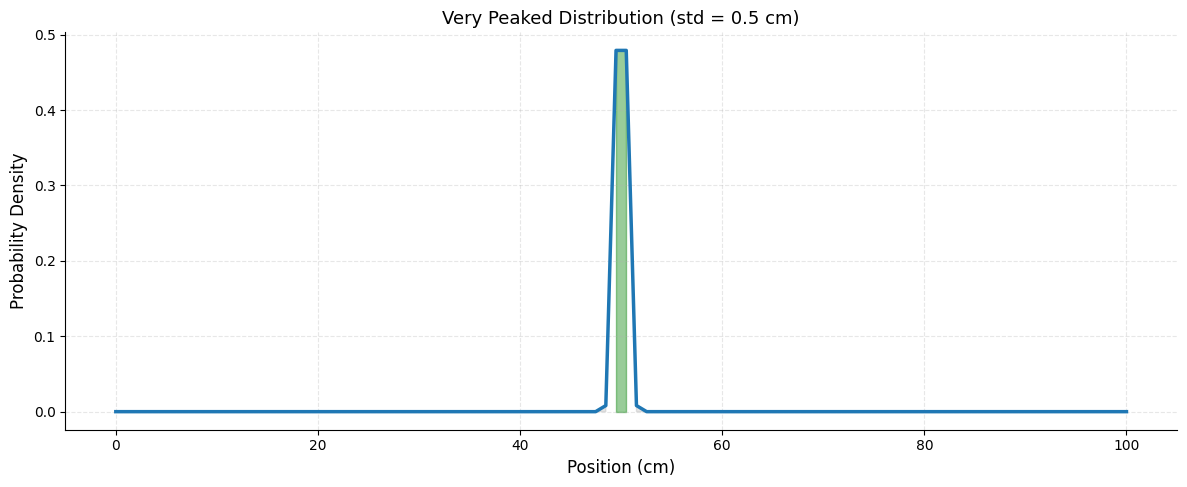

HDR spans 2 bins (out of 100 total)
HDR width: ~2.0 cm


In [8]:
# Extremely narrow distribution
dist_peaked = generate_1d_gaussian_distribution(position_bins, mean=50.0, std=0.5)
dist_peaked_2d = dist_peaked[np.newaxis, :]
hdr_peaked = highest_density_region(dist_peaked_2d, coverage=0.95)[0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(position_bins, dist_peaked, linewidth=2.5, color="#1f77b4")
ax.fill_between(position_bins, 0, dist_peaked, where=hdr_peaked, alpha=0.4, color="green")
ax.fill_between(position_bins, 0, dist_peaked, where=~hdr_peaked, alpha=0.2, color="gray")
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Very Peaked Distribution (std = 0.5 cm)")
plt.tight_layout()
plt.show()

print(f"HDR spans {hdr_peaked.sum()} bins (out of {len(position_bins)} total)")
print(f"HDR width: ~{hdr_peaked.sum() * (position_bins[1] - position_bins[0]):.1f} cm")

**Result:** HDR correctly identifies a very tight region. The algorithm handles highly peaked distributions well.

### Case 2: Very Flat Distribution

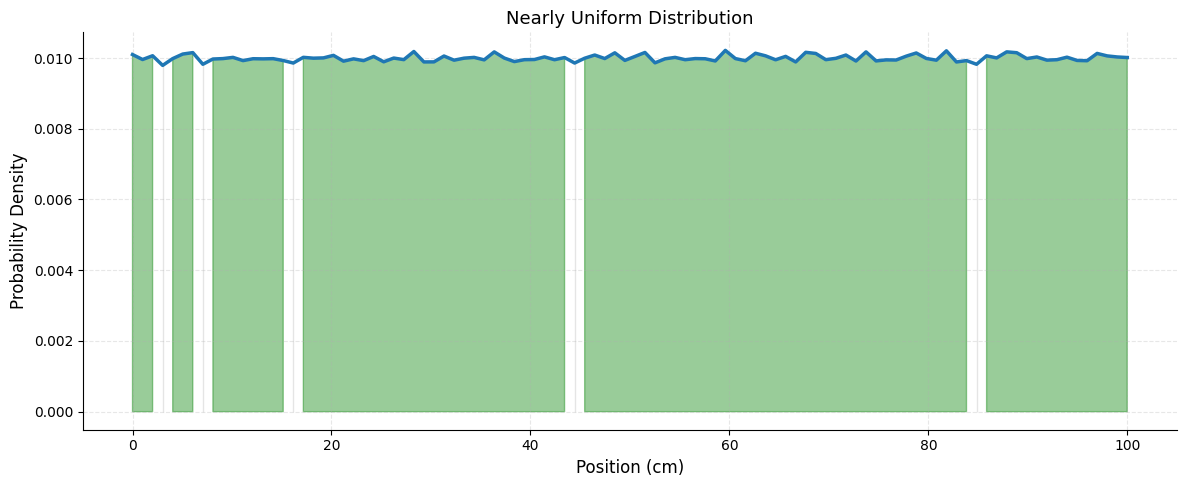

HDR spans 95 bins (out of 100 total)
HDR coverage: 95.0% of bins


In [9]:
# Nearly uniform distribution
dist_flat = np.ones_like(position_bins) + np.random.normal(0, 0.01, len(position_bins))
dist_flat = np.maximum(dist_flat, 0)  # Ensure non-negative
dist_flat = dist_flat / dist_flat.sum()  # Normalize

dist_flat_2d = dist_flat[np.newaxis, :]
hdr_flat = highest_density_region(dist_flat_2d, coverage=0.95)[0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(position_bins, dist_flat, linewidth=2.5, color="#1f77b4")
ax.fill_between(position_bins, 0, dist_flat, where=hdr_flat, alpha=0.4, color="green")
ax.fill_between(position_bins, 0, dist_flat, where=~hdr_flat, alpha=0.2, color="gray")
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Nearly Uniform Distribution")
plt.tight_layout()
plt.show()

print(f"HDR spans {hdr_flat.sum()} bins (out of {len(position_bins)} total)")
print(f"HDR coverage: {hdr_flat.sum() / len(position_bins) * 100:.1f}% of bins")

**Result:** For nearly uniform distributions, HDR includes most of the space (as expected - there's no concentrated region). The algorithm handles flat distributions appropriately.

### Case 3: Distribution with NaN Values

In neuroscience, we often have invalid spatial bins (e.g., walls in a maze, inaccessible regions). We use NaN to mark these.

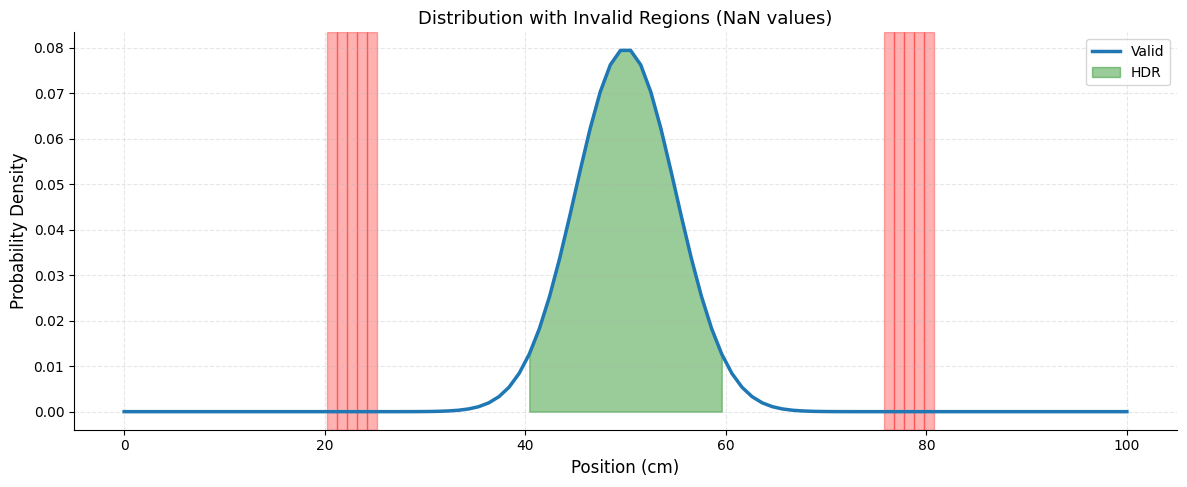

NaN values are correctly excluded from HDR computation
HDR computed only over valid bins


In [10]:
# Create distribution with NaN values (simulating walls/barriers)
dist_with_nan = generate_1d_gaussian_distribution(position_bins, mean=50.0, std=5.0)

# Mark some regions as invalid (e.g., walls)
dist_with_nan[20:25] = np.nan  # Barrier 1
dist_with_nan[75:80] = np.nan  # Barrier 2

dist_with_nan_2d = dist_with_nan[np.newaxis, :]
hdr_with_nan = highest_density_region(dist_with_nan_2d, coverage=0.95)[0]

fig, ax = plt.subplots(figsize=(12, 5))
# Plot valid regions
valid_mask = ~np.isnan(dist_with_nan)
ax.plot(
    position_bins[valid_mask],
    dist_with_nan[valid_mask],
    linewidth=2.5,
    color="#1f77b4",
    label="Valid",
)

# Mark NaN regions
nan_mask = np.isnan(dist_with_nan)
for i in range(len(position_bins) - 1):
    if nan_mask[i]:
        ax.axvspan(position_bins[i], position_bins[i + 1], alpha=0.3, color="red")

# Plot HDR
ax.fill_between(
    position_bins,
    0,
    np.nan_to_num(dist_with_nan, nan=0),
    where=hdr_with_nan & valid_mask,
    alpha=0.4,
    color="green",
    label="HDR",
)

ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution with Invalid Regions (NaN values)")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

print("NaN values are correctly excluded from HDR computation")
print("HDR computed only over valid bins")

**Result:** The algorithm correctly handles NaN values by treating them as invalid bins (zero mass) and excluding them from both normalization and HDR computation.

## Summary: What We Learned

**Core concepts:**
1. HDR identifies where probability mass is concentrated
2. Coverage parameter controls how much mass to include (95% is standard)
3. HDR can be non-contiguous for multimodal distributions
4. HPD overlap measures spatial agreement between distributions

**Key insights:**
- **Unimodal distributions**: HDR is a contiguous interval
- **Multimodal distributions**: HDR can have multiple separated regions
- **Overlap metric**: Normalized by smaller region for interpretability
- **Edge cases**: Algorithm handles peaked, flat, and NaN-containing distributions

**Practical guidelines:**
- Use 95% coverage for consistency with standard practice
- Interpret overlap > 0.7 as good spatial agreement
- Interpret overlap < 0.3 as poor spatial agreement
- Visualize HDR to understand distribution structure

**Next steps:**
- **Next notebook**: [03_time_resolved_diagnostics.ipynb](03_time_resolved_diagnostics.ipynb) - Apply these concepts to time series
- **Jump ahead**: [04_predictive_checks.ipynb](04_predictive_checks.ipynb) - Advanced diagnostics

## Exercises (Optional)

1. Create a trimodal distribution and visualize its 90% HDR
2. For two distributions with 50% overlap, what's the spatial separation?
3. How does HDR overlap change if you use 50% vs 95% coverage?
4. Create a case where KL divergence is low but HDR overlap is also low (is this possible?)